## [1. Import Needed Modules](#import) ##
## [2. ASK Callback Definition](#ask) ## 
## [3. SLR Callback Definition](#slr) ##
## [4. SOMT Callback Definition](#somt) ## 
## [5. TLC Callback Definition](#tlc) ## 
## [6. SPREADSHEET Callback Definition](#spreadsheet) ## 
## [7. DWELL Callback Definition](#dwell) ## 
## [8. LRA Callback Definition](#lra) ## 
## [9. Code to Setup Callback Demonstrations](#setup) ## 
## [10. Demonstration of ASK Callback](#askdemo) ## 
## [11. Demonstration of SLR Callback](#slrdemo) ##
## [12. Demonstration of SOMT Callback](#somtdemo) ##
## [13. Demonstration of TLC Callback](#tlcdemo) ##
## [14. Demonstration of SPREADSHEET Callback](#spreadsheetdemo) ##
## [15. Demonstration of DWELL Callback](#dwelldemo) ##
## [16. Demonstration of DWELL Callback](#dwelldemo) ##

<a id="import"></a>
# <center>Import Need Modules</center>

In [22]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
import numpy as np
import time
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
print ('modules loaded')

modules loaded


## Below are a series of custom callbacks I have found to be very  useful when training a model.  
## The use of these callbacks is demonstrated in the code below. To demonstrate I use this dataset
## with a reduced image size and a smaller number of samples per class to speed up training time
## for the 7 different callbaack demos, Object here is to demo the callbacks and not necessarily
## achieve a high accuracy

<a id="ask"></a>
# <center>ASK Callback Definition</center>

### The ASK callback is useful when training a model and based on model performance metrics you can elect to halt or continue training.
Often when you first run a model you are not sure of how man epochs to run. For example you may initially specify 5 epochs in
model.fit and your model is training well so you would really like to run more epochs but to do that you have to start over
and set epochs to say 15. Conversely you may specify epochs as 100 and your model performance maxes out metric wise at around
10 epochs. So now you have t0 kill the kernel and rerun everything again with epochs set to 15. The ASK callbacks enables you
to easily continue training for an additional number of epochs or halt training. The form of use of the callback is
callbacks=[ASK(model, epochs, ask_epoch)] where
* model is the name of your compiled model
* epochs is the number of epochs you specified in model.fit
* ask_epoch is an integer. Assume it is set to a value N. When the model is training when it completes the Nth epoch you
  will receive a printed query asking if you wish to halt train by entering an H, or to enter an integer say for example 5.
  In that case training will continue up to epoch N+5 at which time you will be queried again. Note however training will
  always end when epochs number of epochs has been run. Typically make epochs a large number like 100 so it does not end training
  before you elect to do so.

In [23]:
class ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training or enter an integer for how many more epochs to run then be asked again')  
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or  an integer for the number of additional epochs to run then ask again')
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

<a id="slr"></a>
# <center>SLR Callback Definition</center>

### The SLR callback is useful if you wish to change the learning rate during training
The callback is a modification of the ASK callback above where when queired you can specify a new learning rate.  
The form of use of the callback is callbacks=[SLR(model, epochs, ask_epoch)] where
* model is the name of your compiled model
* epochs is the number of epochs you specified in model.fit
* ask_epoch is an integer. Assume it is set to a value N. When the model is training when it completes the Nth epoch you
  will receive a printed query asking if you wish to halt train by entering an H, or to enter an integer say for example 5
  to continue training for 5 more epochs using the current learning rate, or enter A to adjusts the learning rate. If you
  enter A you will be queired to enter a float value as the new learning rate. After entering the new learning rate you are
  asked to enter an integer for the number of additional epochs to run then be queired again.

In [24]:
class SLR(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch): # initialization of the callback
        super(SLR, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            print('Training will proceed until epoch', ask_epoch,' then you will be asked to') 
            print(' enter H to halt training, or enter an integer for how many more epochs to run, then be asked again')  
            print(' or enter an A to adjust the learning rate. If an A is entered you will be queired to enter a float')
            print(' values for the new learning rate then be asked to enter an integer for how many more epochs to run before being asked again')
        self.start_time= time.time() # set the time at which training started
        
    def on_train_end(self, logs=None):   # runs at the end of training     
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                print('\n Enter H to end training or an integer for the number of additional epochs to run or enter A to adjust the learning rate')
                ans=input()                
                if ans == 'H' or ans =='h' or ans == '0': # halt training 
                    print ('you entered ', ans, ' Training halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True # halt training
                elif ans == 'A' or ans == 'a': # user wants to adjust learning rate
                    lr=float(tf.keras.backend.get_value(self.model.optimizer.lr))
                    print(' current lr = ', lr, 'Enter a float value for the new learning rate')
                    ans=input()
                    lr=float(ans)
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    print('Enter an integer for the number of additional epochs to run then be asked again')
                    ans=input()
                    self.ask_epoch += int (ans)
                    print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)
                else: # user wants to continue training with current lr
                    self.ask_epoch += int(ans)
                    print ('you entered ', ans, ' Training will continue to epoch ', self.ask_epoch, flush=True)

<a id="somt"></a>
# <center>SOMT Callback Definition</center>

### The SOMT callback is useful to end training based on the value of the training accuracy or the validation loss or both.
The form of use is callbacks=[SOMT(model, train_thold, valid_thold)] where

* model is the name of your complied model
* train_thold is a float. It is the value of accuracy (in Percent) that must be achieved by the model in order to conditionally stop training
* valid_threshold is a float. It is the value of validation accuracy (in Percent) that must be achieved by the model
  in order to conditionally stop training

Note to stop training BOTH the train_thold and valid_thold must be exceeded in the SAME epoch.   
If you want to stop training based soley on the training accuracy set the valid_thold to 0.0.  
Similarly if you want to stop training on just validation accuracy set train_thold= 0.0.   
Note if both thresholds are not achieved in the same epoch training will continue until the value of epochs  
set in model.fit is reached. For example lets take the case that you want to stop training when the   
training accuracy has reached or exceeded 95 % and the validation accuracy has achieved at least 85%   
then the code would be callbacks=[SOMT(my_model, .95, .85)]

In [25]:
class SOMT(keras.callbacks.Callback):
    def __init__(self, model,  train_thold, valid_thold):
        super(SOMT, self).__init__()
        self.model=model        
        self.train_thold=train_thold
        self.valid_thold=valid_thold
        
    def on_train_begin(self, logs=None):
        print('Starting Training - training will halt if training accuracy achieves or exceeds ', self.train_thold)
        print ('and validation accuracy meets or exceeds ', self.valid_thold) 
        msg='{0:^8s}{1:^12s}{2:^12s}{3:^12s}{4:^12s}{5:^12s}'.format('Epoch', 'Train Acc', 'Train Loss','Valid Acc','Valid_Loss','Duration')
        print (msg)                                                                                    
            
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:1s}processed batch {1:4s}  training accuracy= {2:8.3f}  loss: {3:8.5f}'.format(' ', str(batch),  acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count 
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self,epoch, logs=None): 
        later=time.time()
        duration=later-self.now 
        tacc=logs.get('accuracy')           
        vacc=logs.get('val_accuracy')
        tr_loss=logs.get('loss')
        v_loss=logs.get('val_loss')
        ep=epoch+1
        print(f'{ep:^8.0f} {tacc:^12.2f}{tr_loss:^12.4f}{vacc:^12.2f}{v_loss:^12.4f}{duration:^12.2f}')
        if tacc>= self.train_thold and vacc>= self.valid_thold:
            print( f'\ntraining accuracy and validation accuracy reached the thresholds on epoch {epoch + 1}' )
            self.model.stop_training = True # stop training

<a id="tlc"></a>
# <center>TLC Callback Definition</center>

The TLC callback is a variation of the ASK callback that is useful in the case where you are doing transfer learning.   
The form of use is callbacks=[TLC(model, base_model,epochs, ask_epoch)] where
* model is the name of your compiled model
* base_model is the name of the base model providing transfer learning. For example in the code below I create a model using the
  EfficientNetB3 as the base_model. 
   * base_model=tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
   * base_model.trainable= False    
   * x=base_model.output 
   * x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
   * x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
     bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
   * x=Dropout(rate=.45, seed=123)(x)
   * output=Dense(class_count, activation='softmax')(x) 
   * my_model=Model(inputs=base_model.input, outputs=output) 
   * my_model.compile(Adamax(lr=.005), loss='categorical_crossentropy', metrics=['accuracy'])
     Note make sure you include base_model.trainable=False so that when queried you can provide an input T to make the base_model trainable when asked
  
  
 * ask_epoch is an integer. Lets it is set to 5. In that case at the end of the 5th epoch you will be queried to enter either  
   T to make the base_model trainable or enter an integer say 4. In that case at the end of the 9th epoch you will be queried again.  
   If you enter T to make the base_model trainable you will then be asked to enter an integer N say you enter 3.   
   Then you will train the model for 3 more epochs then be asked to either enter H to halt training or enter an integer  
   for how many more epochs to run then be queried again.  
 * epochs is the value of epochs you used in model.fit

In [26]:
class TLC(keras.callbacks.Callback):
    def __init__(self, model, base_model, epochs,  ask_epoch):
        super(TLC, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True
        self.base_model=base_model        
        
    def on_train_begin(self, logs=None):        
        if self.ask_epoch == 0:
            self.ask=False
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs:
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs' )           
            self.ask=False
        if self.epochs == 1:
            self.ask=False
        else:
            if self.base_model !=None and self.base_model.trainable == False:                
                msg=f'Training will proceed until epoch {ask_epoch}, then you will be asked to either halt, continue \n'
                msg=msg + 'or make the base model trainable then asked to enter number of epochs to run then ask again\n'
                print (msg, flush=True)
            else:
                msg=f'Training will proceed until epoch {ask_epoch}, then you will be asked to either halt \n'
                msg=msg + 'or enter the number of epochs to train on then you will be asked again\n'
                print (msg, flush=True)
            
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):        
        tr_duration=time.time() - self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print (msg, flush=True) 
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        if self.ask:
            if epoch + 1 ==self.ask_epoch:                
                if self.base_model !=None and self.base_model.trainable ==  False:
                    msg='\n Enter H to end training,an integer for the number of additional epochs to run then ask again\n'
                    msg=msg + 'or T to train base model\n'                    
                else:
                    msg='\n Enter H to end training,an integer for the number of additional epochs to run then ask again\n'
                ans=input(msg )
                if ans == 'T' or ans== 't':
                    self.base_model.trainable=True
                    print ('Base Model trainable is now set to ', self.base_model.trainable)
                    msg='\n enter an integer for the number of additional epochs to run then ask again\n'
                    ans=(input(msg))
                    
                if ans == 'H' or ans =='h' or ans == '0':
                    print ('\nTraining halted on epoch ', epoch+1, ' due to user input\n', flush=True)
                    self.model.stop_training = True
                else:
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush=True)
                    else:
                        print ('\n Training will continue to epoch ', self.ask_epoch, flush=True)

<a id="spreadsheet"></a>
# <center>SPREADSHEET Callback Definition</center>

The SPREADSHEET callback formats the printout used during training in a spreadsheet style. It has the same fuctionality  
as the TLC callback but prints out the training data in the example format shown below.  
The form of use is  callbacks=[SPREADSHEET(model, base_model, epochs, ask_epoch, batches)] where  
* model is the name of your compiled model
* base_model is the name of the base model providing transfer learning.  
  If you are not doing transfer learning set base_model=None.  
  For example in the code below I create a model using the EfficientNetB3 as the base_model.   
   * base_model=tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')
   * base_model.trainable= False    
   * x=base_model.output 
   * x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
   * x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
     bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
   * x=Dropout(rate=.45, seed=123)(x)
   * output=Dense(class_count, activation='softmax')(x) 
   * my_model=Model(inputs=base_model.input, outputs=output) 
   * my_model.compile(Adamax(lr=.005), loss='categorical_crossentropy', metrics=['accuracy'])
     Note make sure you include base_model.trainable=False so that when queried you can provide an input T to make the base_model trainable when asked
  
  
 * ask_epoch is an integer. Lets say it is set to 5. In that case at the end of the 5th epoch  
   you will be queried to enter either T to make the base_model trainable or enter an integer say 4.  
   In that case at the end of the 9th epoch you will be queried again.  
   If you enter T to make the base_model trainable you will then be asked to enter an integer N say you enter 3.   
   Then you will train the model for 3 more epochs then be asked to either enter H to halt training or enter an integer  
   for how many more epochs to run then be queried again.
 * epochs is the value of epochs you used in model.fit
 * batches is an integer that defines the number of batches that are run per epoch.   
   This can be calculated as the number of samples in the training set divided by the batch size.  
   Use batches=np.celing(training samples/batch_size). For example if your training  
   set has say 1,000 images and a batch size of 50, then batches would be 20.
  


In [27]:
class SPREADSHEET(keras.callbacks.Callback):
    def __init__(self, model, base_model, epochs,  ask_epoch, batches):
        super(SPREADSHEET, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True
        self.base_model=base_model 
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.batches=batches        
        
    def on_train_begin(self, logs=None): 
        if self.ask_epoch == 0:
            self.ask=False            
        if self.ask_epoch >= self.epochs:
            msg=f'ask_epoch >= epochs, will train for {epochs}  epochs'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.ask=False
        if self.epochs == 1:
            self.ask=False
        if self.ask == True:
            if self.base_model !=None and self.base_model.trainable == False:                
                msg=f'Training will proceed until epoch {ask_epoch}, then you will be asked to either halt, continue \n'
                msg=msg + 'or make the base model trainable then asked to enter number of epochs to run then ask again\n'
                print_in_color (msg, (0,255,255), (55,65,80))
            else:
                msg=f'Training will proceed until epoch {ask_epoch}, then you will be asked to either halt \n'
                msg=msg + 'or enter the number of epochs to train on then you will be asked again\n'
                print_in_color (msg, (0,255,255), (55,65,80))
            
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:10s}{7:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', '% Improv', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):        
        tr_duration=time.time() - self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color (msg, (0,255,255), (55,65,80)) 
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        color= (0,255,0)
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        if epoch ==0:
                pimprov=0.0
                self.lowest_vloss=v_loss
        else:
            pimprov=( self.lowest_vloss- v_loss) * 100/self.lowest_vloss
            if v_loss > self.lowest_vloss:
                color=(245, 170, 66)
            else:
                color=(0,255,0)
                self.lowest_vloss=v_loss
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss') 
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{pimprov:^10.2f}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.ask:
            if epoch + 1 ==self.ask_epoch:                
                if self.base_model !=None and self.base_model.trainable ==  False:
                    msg='\n Enter H to end training,an integer for the number of additional epochs to run then ask again\n'
                    msg=msg + 'or T to train base model\n'                    
                else:
                    msg='\n Enter H to end training,an integer for the number of additional epochs to run then ask again\n'
                ans=input(msg )
                if ans == 'T' or ans== 't':
                    self.base_model.trainable=True
                    msg=f'Base Model trainable is now set to {self.base_model.trainable}'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    msg=' enter an integer for the number of additional epochs to run then ask again'
                    ans=(input(msg))
                    
                if ans == 'H' or ans =='h' or ans == '0':
                    msg=f'\nTraining halted on epoch {epoch+1} due to user input'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    self.model.stop_training = True
                else:
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        msg=f'\nYou specified maximum epochs of as {self.epochs}, cannot train for {self.ask_epoch} '
                        print_in_color(msg, (244,252,3), (55,65,80))
                    else:
                        print ('\n Training will continue to epoch ', self.ask_epoch, flush=True)
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:10s}{7:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', '% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80)) 

<a id="dwell"></a>
# <center>DWELL Callback Definition</center>

The DWELL callback if useful when training a model and the validation loss on the current epoch exceeds that of the previous epoch.    
When that is the case your model has moved to a point in Nspace(N being the number of trainable parameters) that is less favorable  
than that for the previous epoch. What the callback does is to detect this condition and if it occurs it sets the model weights to  
those of the  epoch with the lowesy validation loss. It also reduces the learning rate.  
If you do not change the learning rate on the next epoch you would end up in the same unfavorable point in Nspace.  
Use of the callback is of the form    
callbacks=[DWELL(model, factor, verbose)] where :
* model is the name of your compiled model
* factor is a float between 0 and 1. The new learning rate is given by new_lr= current_lr * factor
* verbose is a boolean. If verbose is True if the condition occurs, a print out is generated for the current epoch that advises the  
  model weights have been set to the weights of the epoch with the lowest validation loss and it prints out the reduced learning rate 

In [28]:
class DWELL(keras.callbacks.Callback):
    def __init__(self,model,  factor, verbose):
        super(DWELL, self).__init__()
        self.model=model
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it  
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights 
        self.verbose=verbose 
        self.best_epoch=0
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate         
        vloss=logs.get('val_loss')  # get the validation loss for this epoch 
        if vloss>self.lowest_vloss:
            self.model.set_weights(self.best_weights)
            new_lr=lr * factor
            tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
            if self.verbose:
                print( '\n model weights reset to best weights from epoch ', self.best_epoch+1, ' and reduced lr to ', new_lr, flush=True)
        else:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights()
            self.best_epoch= epoch
        

<a id="lra"></a>
# <center>LRA Callback Definition</center>

The LRA callback is somewhat a combination of the DWELL and SPREADSHEET callback with additional features.  
The form of the callback is   
callbacks=[LRA(model, base_model, patience,stop_patience, threshold, factor, dwell, batches,epochs, ask_epoch)] where  
* model is the name of your compiled model
* base_model is the name of the base_model used for transfer learning. If not doing transfer learning set base_model=None
* patience is an integer. This callback initially monitors the training accuracy. If the training accuracy fails to improve  
  after patience number of epochs the learning rate is reduced where new_lr=old_lr * factor.   
  The training accuracy is monitored until it achieves or exceeds the float value threshold.   
  At that point the callback now monitors validation loss.  
  If the validation loss fails to decrease for patience number of epochs the learning rate is adjusted.   
  The callback always saves the weights for the epoch with the lowest validation loss.  
  At the conclusion of training the best weights are loaded  into the model.
* stop_patience is an integer. If stop_patience number of consecutive epochs occur where the learning rate was reduced  
   but the metric being monitored idi not improve the training is halted.
* threshold is a float between 0 and 1.0. It is the level the training accuracy must meet or exceed for the callback to   
   switch to monitoring validation loss.
* factor is a float between 0 and 1.0. It determines the new learning rate by the formula new_lr=old_lr * factor 
* dwell is a boolean. When dwell=True the callback monitors the metric. If the metric fails to improve on the current epoch    
   it means you have moved to a point in Nspace(N is the number of trainable parameters of the model) that is NOT as good in  
   terms of the metric value as was the point for the epoch with the best metric performance. So the callback loads the   
   model with the weights from that epoch. It then reduces the learning rate and continues training. If dwell=False the  
   scenario described does not occur. However your model always ends up with the weights for the epoch with the best metric  
   performance laded in the model.
* batches is an integer used only for printing purposes. It's value should be the same as train_steps, that is calculated as  
   batches = number of training samples//batch_size +1. For example if you have 1001 samples and your batch_size is 10  
   then batches= 10 + 1 = 11.
* epochs is an integer and is the value of epochs you use for model.fit
* ask_epoch is an integer. Lets say it is set to a value N. After the model trains for N epochs the user is queired to provide    
   input. If an integer is entered say M then training will continue for M more epochs and at the end of epoch M + N the    
   user is queried again. If the user enters another integer the process continues until epochs number of epochs is run.  
   If the user is doing transfer learning whene the vale of base_model is NOT None at the query you can enter a T. This will    
   make the base_model trainable. After entering T you will be queried to enter an integer for how many more epochs to run  
   before you are queried again. At any query you have the option to enter H to halt training.  
   
 See the LRA callback demo for demonstration of use.

In [29]:
class LRA(keras.callbacks.Callback):
    def __init__(self,model, base_model, patience,stop_patience, threshold, factor, dwell, batches,epochs, ask_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.base_model=base_model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.batches=batches # number of training batch to runn per epoch        
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch # save this value to restore if restarting training
        # callback variables 
        self.count=0 # how many times lr has been reduced without improvement
        self.stop_count=0        
        self.best_epoch=1   # epoch with the lowest loss        
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it         
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored 
        
    def on_train_begin(self, logs=None):        
        if self.base_model != None:
            status=base_model.trainable
            if status:
                msg=' initializing callback starting training with base_model trainable'
            else:
                msg='initializing callback starting training with base_model not trainable'
        else:
            msg='initialing callback and starting training'                        
        print_in_color (msg, (244, 252, 3), (55,65,80)) 
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print_in_color(msg, (244,252,3), (55,65,80)) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print_in_color(msg, (0,255,0), (55,65,80))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print_in_color(msg, (0,255,0), (55,65,80))   
        
    def on_train_batch_end(self, batch, logs=None):
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count        
        
    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')        
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (acc-self.highest_tracc )*100/self.highest_tracc
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch              
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if epoch ==0:
                pimprov=0.0
            else:
                pimprov= (self.lowest_vloss- v_loss )*100/self.lowest_vloss
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,255), (55,65,80))
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    if base_model.trainable:
                        msg='enter H to halt training or an integer for number of epochs to run then ask again'
                    else:
                        msg='enter H to halt training ,T to train the base_model, or an integer for number of epochs to run then ask again'
                    print_in_color(msg, (0,255,255), (55,65,80))
                    ans=input('')                    
                    if ans=='H' or ans=='h':
                        msg=f'training has been halted at epoch {epoch + 1} due to user input'
                        print_in_color(msg, (0,255,255), (55,65,80))
                        self.model.stop_training = True # stop training
                    elif ans == 'T' or ans=='t':
                        if base_model.trainable:
                            msg='base_model is already set as trainable'
                        else:
                            msg='setting base_model as trainable for fine tuning of model'
                            self.base_model.trainable=True
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='Enter an integer for the number of epochs to run then be asked again'
                        print_in_color(msg, (0,2555,255), (55,65,80))
                        ans=input()
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch) 
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80))                         
                        self.count=0
                        self.stop_count=0                        
                        self.ask_epoch = epoch + 1 + self.ask_epoch_initial 
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print_in_color(msg, (0, 255,255), (55,65,80))
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
                        print_in_color(msg, (244,252,3), (55,65,80)) 

<a id="setup"></a>
# <center>Setup code to demo the callbacks</center>

### The function below prints a text message in rgb foreground colors and rgb background colors
### it is used by some  of the callbacks to provide a easier to see output

In [30]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):    
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple 
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

## input an image and get the shape

Image shape is:  (1024, 1024, 3)


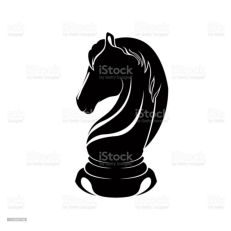

In [31]:
img_path=r'../input/chess-pieces-detection-images-dataset/KnightImages/00000001.jpg'
img=plt.imread(img_path)
print ('Image shape is: ', img.shape)
plt.axis('off')
plt.imshow(img)

### create a dataframe of the form filepaths(path to the image file), labels (class label of the image file)

In [32]:
sdir=r'../input/chess-pieces-detection-images-dataset'
classlist=os.listdir(sdir)
labels=[]
filepaths=[]
for klass in classlist:
    classpath=os.path.join(sdir, klass)
    flist=os.listdir(classpath)
    for f in flist:
        fpath=os.path.join(classpath,f)
        filepaths.append(fpath)
        labels.append(klass)
Fseries=pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1)
class_count=len(list(df['labels'].unique()))
print('Number of classes in dataset is ', class_count)

Number of classes in dataset is  5


# split df into a train_df, a test_df and a valid df

In [33]:
train_df, dummy_df =train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify= df['labels'])
valid_df, test_df = train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify =dummy_df['labels'])
print('train_df length: ', len(train_df), '  test_df length: ',len(test_df), '  valid_df length: ', len(valid_df))
print (train_df['labels'].value_counts())

train_df length:  606   test_df length:  34   valid_df length:  34
KnightImages    156
bishopImages    148
RookImage       125
Queenimages     103
PawnImages       74
Name: labels, dtype: int64


## train_df is  not balanced the trim function below will limit the number of samples in each class to max_samples which
## will be set to 74. This will of course reduce accuracy but I want to have short training times. I also limit the
## image size to 100 X 100 to speed up training

In [34]:
def trim (df, max_size, min_size, column):
    df=df.copy()
    original_class_count= len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    sample_list=[] 
    groups=df.groupby(column)
    for label in df[column].unique():        
        group=groups.get_group(label)
        sample_count=len(group)         
        if sample_count> max_size :
            strat=group[column]
            samples,_=train_test_split(group, train_size=max_size, shuffle=True, random_state=123, stratify=strat)            
            sample_list.append(samples)
        elif sample_count>= min_size:
            sample_list.append(group)
    df=pd.concat(sample_list, axis=0).reset_index(drop=True)
    final_class_count= len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance=list(df[column].value_counts())
    print (balance)
    return df

In [35]:
max_samples=74
min_samples=0
column='labels'
train_df=trim(train_df, max_samples, min_samples, column, )

Original Number of classes in dataframe:  5
[74, 74, 74, 74, 74]


## all classes now have 74 training samples. Create train, test and validation generators

In [36]:
img_size = (100,100)
working_dir = r'./'
batch_size= 40
# calculate test_batch_size and test_step so we go through test files exactly once
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ('test batch size= ', test_batch_size, '  test steps= ', test_steps)
trgen=ImageDataGenerator(horizontal_flip=True)
tvgen=ImageDataGenerator()
train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
valid_gen=tvgen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=tvgen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)


test batch size=  34   test steps=  1
Found 370 validated image filenames belonging to 5 classes.
Found 34 validated image filenames belonging to 5 classes.
Found 34 validated image filenames belonging to 5 classes.


## Use transfer learning with EfficientNetB3 model
This function creates the model. It is set up for transfer learning. Parameter trainable determines
if the base model is trainable. The TLC callback can be used to control this state of the base model
for those that want to start training with the base model not trainable then after a specified number
of epochs make the base_model trainable

In [37]:
def make_model(img_img_size, class_count,lr=.001, trainable=True):
    img_shape=(img_size[0], img_size[1], 3)
    model_name='EfficientNetB3'
    base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
    base_model.trainable=trainable
    x=base_model.output
    x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
    x=Dropout(rate=.45, seed=123)(x)        
    output=Dense(class_count, activation='softmax')(x)
    model=Model(inputs=base_model.input, outputs=output)
    model.compile(Adamax(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy']) 
    return model, base_model # return the base_model so the callback can control its training state

<a id="askdemo"></a>
# <center>ASK Callback Demonstration</center>

In [38]:
epochs=40 # max number of epochs to run unless training is halted by the user
ask_epoch=5 # set number of epochs to run then be quired to contiue or halt
lr=.002 # set the optimizer learning rate
trainable=True # set base_model trainable
model, _=make_model(img_size, class_count, lr,)
callbacks=[ASK(model, epochs,  ask_epoch)]

## train the model 

In [39]:
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5  then you will be asked to
 enter H to halt training or enter an integer for how many more epochs to run then be asked again
Epoch 1/40
 6/10 [=================>............] - ETA: 1s - loss: 10.3243 - accuracy: 0.2417

/opt/conda/lib/python3.7/site-packages/PIL/Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


10/10 [==============================] - 19s 762ms/step - loss: 10.0993 - accuracy: 0.3081 - val_loss: 13.8539 - val_accuracy: 0.2647
Epoch 2/40
10/10 [==============================] - 5s 501ms/step - loss: 8.8755 - accuracy: 0.5270 - val_loss: 10.9114 - val_accuracy: 0.4706
Epoch 3/40
10/10 [==============================] - 5s 496ms/step - loss: 8.0016 - accuracy: 0.6919 - val_loss: 11.6428 - val_accuracy: 0.5294
Epoch 4/40
10/10 [==============================] - 5s 424ms/step - loss: 7.4355 - accuracy: 0.7649 - val_loss: 9.5179 - val_accuracy: 0.5882
Epoch 5/40
10/10 [==============================] - 5s 466ms/step - loss: 6.9288 - accuracy: 0.8514 - val_loss: 8.3931 - val_accuracy: 0.6765

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 3


you entered  3  Training will continue to epoch  8
Epoch 6/40
10/10 [==============================] - 5s 489ms/step - loss: 6.5038 - accuracy: 0.9081 - val_loss: 7.8253 - val_accuracy: 0.6765
Epoch 7/40
10/10 [==============================] - 5s 492ms/step - loss: 6.2238 - accuracy: 0.8649 - val_loss: 6.9767 - val_accuracy: 0.7353
Epoch 8/40
10/10 [==============================] - 5s 487ms/step - loss: 5.9284 - accuracy: 0.9054 - val_loss: 6.3513 - val_accuracy: 0.8235

 Enter H to end training or  an integer for the number of additional epochs to run then ask again


 h


you entered  h  Training halted on epoch  8  due to user input

training elapsed time was 0.0 hours,  1.0 minutes, 4.01 seconds)


<a id="slrdemo"></a>
# <center>SLR Callback Demonstration</center>

In [40]:
del model # delete the current model
K.clear_session() #clear the session
tf.compat.v1.reset_default_graph()
model, _=make_model(img_size, class_count) # recreate the model - so it starts fresh with new initialized weights
ask_epoch=5 # epoch to query user
epochs=40  # total epochs to run unless halted by the callback
callbacks=[SLR(model, epochs,  ask_epoch)] # instantiate the callback
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5  then you will be asked to
 enter H to halt training, or enter an integer for how many more epochs to run, then be asked again
 or enter an A to adjust the learning rate. If an A is entered you will be queired to enter a float
 values for the new learning rate then be asked to enter an integer for howmany more epochs to run before being asked again
Epoch 1/40
10/10 [==============================] - 20s 767ms/step - loss: 9.8134 - accuracy: 0.3000 - val_loss: 10.7592 - val_accuracy: 0.3529
Epoch 2/40
10/10 [==============================] - 5s 495ms/step - loss: 8.8045 - accuracy: 0.5622 - val_loss: 9.1871 - val_accuracy: 0.4706
Epoch 3/40
10/10 [==============================] - 5s 498ms/step - loss: 8.1247 - accuracy: 0.7378 - val_loss: 8.9415 - val_accuracy: 0.4412
Epoch 4/40
10/10 [==============================] - 5s 494ms/step - loss: 7.7688 - accuracy: 0.8081 - val_loss: 8.9533 - val_accuracy: 0.5294
Epoch 5/40
10/10 [=========================

 2


you entered  2  Training will continue to epoch  7
Epoch 6/40
10/10 [==============================] - 5s 497ms/step - loss: 7.2039 - accuracy: 0.9054 - val_loss: 8.1911 - val_accuracy: 0.7059
Epoch 7/40
10/10 [==============================] - 5s 452ms/step - loss: 7.0336 - accuracy: 0.9216 - val_loss: 7.6929 - val_accuracy: 0.7353

 Enter H to end training or an integer for the number of additional epochs to run or enter A to adjust the learning rate


 A


 current lr =  0.0010000000474974513 Enter a float value for the new learning rate


 .0005


Enter an integer for the number of additional epochs to run then be asked again


 4


you entered  4  Training will continue to epoch  11
Epoch 8/40
10/10 [==============================] - 5s 446ms/step - loss: 6.8831 - accuracy: 0.9405 - val_loss: 7.4516 - val_accuracy: 0.7059
Epoch 9/40
10/10 [==============================] - 5s 411ms/step - loss: 6.8544 - accuracy: 0.9216 - val_loss: 7.2875 - val_accuracy: 0.7059
Epoch 10/40
10/10 [==============================] - 5s 475ms/step - loss: 6.7145 - accuracy: 0.9486 - val_loss: 7.1347 - val_accuracy: 0.7353
Epoch 11/40
10/10 [==============================] - 5s 501ms/step - loss: 6.6184 - accuracy: 0.9568 - val_loss: 7.0453 - val_accuracy: 0.7059

 Enter H to end training or an integer for the number of additional epochs to run or enter A to adjust the learning rate


 a


 current lr =  0.0005000000237487257 Enter a float value for the new learning rate


 .001


Enter an integer for the number of additional epochs to run then be asked again


 2


you entered  2  Training will continue to epoch  13
Epoch 12/40
10/10 [==============================] - 5s 488ms/step - loss: 6.5208 - accuracy: 0.9568 - val_loss: 6.9046 - val_accuracy: 0.7059
Epoch 13/40
10/10 [==============================] - 5s 486ms/step - loss: 6.3961 - accuracy: 0.9568 - val_loss: 6.7218 - val_accuracy: 0.7647

 Enter H to end training or an integer for the number of additional epochs to run or enter A to adjust the learning rate


 h


you entered  h  Training halted on epoch  13  due to user input

training elapsed time was 0.0 hours,  2.0 minutes, 20.18 seconds)


<a id="somtdemo"></a>
# <center>SOMT Callback Demonstration</center>

In [41]:
del model # delete the current model
K.clear_session() #clear the session
tf.compat.v1.reset_default_graph()
model, _=make_model(img_size, class_count) # recreate the model - so it starts fresh with new initialized weights
epochs=40 #  total epochs to run unless halted by the callback
tr_thold=.8 # set training accuracy threshold
v_thold=.75 # set validation accuracy threshold
callbacks=[SOMT(model, tr_thold, v_thold)] # instantiate the callback
# ****************NOTE - set verbose=0 in model.fit so printouts do not conflict**********************
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Starting Training - training will halt if training accuracy achieves or exceeds  0.8
and validation accuracy meets or exceeds  0.75
 Epoch   Train Acc   Train Loss  Valid Acc   Valid_Loss   Duration  
   1         0.30       9.7579       0.29      11.8249      20.23    
   2         0.57       8.7865       0.50       9.4722       4.87    
   3         0.72       8.1335       0.56       9.2530       5.58    
   4         0.79       7.7188       0.56       9.0198       4.82    
   5         0.86       7.3901       0.71       8.3449       5.12    
   6         0.88       7.1788       0.71       7.7619       4.87    
   7         0.92       6.9319       0.71       7.5456       5.07    
   8         0.90       6.8250       0.68       7.4113       4.78    
   9         0.93       6.6043       0.71       7.1365       5.53    
   10        0.95       6.4410       0.71       6.9906       4.81    
   11        0.94       6.2689       0.71       6.8380       4.76    
   12        0.94       6.140

<a id="tlcdemo"></a>
# <center>TLC Callback Demonstration</center>

In [42]:
del model # delete the current model
K.clear_session() #clear the session
tf.compat.v1.reset_default_graph()
# ************NOTE base_model trainable set equal to False in code below when model is created*************
model, base_model=make_model(img_size, class_count, trainable=False) # recreate the model - so it starts fresh with new initialized weights
epochs=40 #  total epochs to run unless halted by the callback
ask_epoch=5
callbacks=[TLC(model, base_model, epochs,  ask_epoch)] # instantiate the callback

history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Training will proceed until epoch 5, then you will be asked to either halt, continue 
or make the base model trainable then asked to enter number of epochs to run then ask again

Epoch 1/40
10/10 [==============================] - 14s 709ms/step - loss: 9.7980 - accuracy: 0.3243 - val_loss: 9.5893 - val_accuracy: 0.4706
Epoch 2/40
10/10 [==============================] - 4s 443ms/step - loss: 8.7069 - accuracy: 0.5405 - val_loss: 8.9553 - val_accuracy: 0.6176
Epoch 3/40
10/10 [==============================] - 4s 445ms/step - loss: 8.3771 - accuracy: 0.6486 - val_loss: 8.6678 - val_accuracy: 0.5882
Epoch 4/40
10/10 [==============================] - 5s 536ms/step - loss: 7.9827 - accuracy: 0.6919 - val_loss: 8.3664 - val_accuracy: 0.5588
Epoch 5/40
10/10 [==============================] - 4s 454ms/step - loss: 7.6550 - accuracy: 0.7405 - val_loss: 7.9790 - val_accuracy: 0.5882



 Enter H to end training,an integer for the number of additional epochs to run then ask again
or T to train base model
 5



 Training will continue to epoch  10
Epoch 6/40
10/10 [==============================] - 4s 447ms/step - loss: 7.4310 - accuracy: 0.7622 - val_loss: 7.7937 - val_accuracy: 0.7059
Epoch 7/40
10/10 [==============================] - 5s 472ms/step - loss: 7.3078 - accuracy: 0.7622 - val_loss: 7.6479 - val_accuracy: 0.6765
Epoch 8/40
10/10 [==============================] - 4s 443ms/step - loss: 7.0443 - accuracy: 0.8000 - val_loss: 7.4941 - val_accuracy: 0.6471
Epoch 9/40
10/10 [==============================] - 5s 540ms/step - loss: 6.9201 - accuracy: 0.8135 - val_loss: 7.2742 - val_accuracy: 0.6471
Epoch 10/40
10/10 [==============================] - 4s 378ms/step - loss: 6.6795 - accuracy: 0.8568 - val_loss: 7.0732 - val_accuracy: 0.6471



 Enter H to end training,an integer for the number of additional epochs to run then ask again
or T to train base model
 T


Base Model trainable is now set to  True



 enter an integer for the number of additional epochs to run then ask again
 5



 Training will continue to epoch  15
Epoch 11/40
10/10 [==============================] - 5s 426ms/step - loss: 6.5994 - accuracy: 0.8351 - val_loss: 6.9247 - val_accuracy: 0.6471
Epoch 12/40
10/10 [==============================] - 4s 447ms/step - loss: 6.3866 - accuracy: 0.8811 - val_loss: 6.8242 - val_accuracy: 0.6471
Epoch 13/40
10/10 [==============================] - 4s 450ms/step - loss: 6.2584 - accuracy: 0.8811 - val_loss: 6.6970 - val_accuracy: 0.6176
Epoch 14/40
10/10 [==============================] - 5s 384ms/step - loss: 6.1337 - accuracy: 0.9000 - val_loss: 6.5565 - val_accuracy: 0.6471
Epoch 15/40
10/10 [==============================] - 4s 443ms/step - loss: 6.0031 - accuracy: 0.9081 - val_loss: 6.4736 - val_accuracy: 0.5882



 Enter H to end training,an integer for the number of additional epochs to run then ask again
 5



 Training will continue to epoch  20
Epoch 16/40
10/10 [==============================] - 4s 444ms/step - loss: 5.8579 - accuracy: 0.9216 - val_loss: 6.3790 - val_accuracy: 0.5882
Epoch 17/40
10/10 [==============================] - 4s 453ms/step - loss: 5.7631 - accuracy: 0.8811 - val_loss: 6.2282 - val_accuracy: 0.6176
Epoch 18/40
10/10 [==============================] - 5s 482ms/step - loss: 5.6381 - accuracy: 0.9000 - val_loss: 6.1155 - val_accuracy: 0.6176
Epoch 19/40
10/10 [==============================] - 4s 445ms/step - loss: 5.5157 - accuracy: 0.9135 - val_loss: 6.0262 - val_accuracy: 0.5882
Epoch 20/40
10/10 [==============================] - 5s 489ms/step - loss: 5.4730 - accuracy: 0.8946 - val_loss: 5.9384 - val_accuracy: 0.5882



 Enter H to end training,an integer for the number of additional epochs to run then ask again
 h



Training halted on epoch  20  due to user input

training elapsed time was 0.0 hours,  2.0 minutes, 31.71 seconds)


<a id="spreadsheetdemo"></a>
# <center>SPREADSHEET Callback Demonstration</center>

In [43]:
del model # delete the current model
K.clear_session() #clear the session
tf.compat.v1.reset_default_graph()
model, base_model=make_model(img_size, class_count, trainable=False) # recreate the model - so it starts fresh with new initialized weights
epochs=40 #  total epochs to run unless halted by the callback
ask_epoch=5
batches=int(np.ceil(len(train_gen.labels)/batch_size)) # number of batches in an epoch is number of samples/batch_size used in generator
# *****NOTE the SPREADSHEET callback requires the print_in_color function be present
callbacks=[SPREADSHEET(model, base_model, epochs,  ask_epoch, batches)] # instantiate the callback
#************NOTE set verbose=0 to prevent model.fit printout*******************
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)



Training will proceed until epoch 5, then you will be asked to either halt, continue 
or make the base model trainable then asked to enter number of epochs to run then ask again


 Epoch     Loss   Accuracy  V_loss    V_acc     LR    % Improv  Duration

 1 /40     9.775   29.189   9.44262  47.059   0.00100    0.00    14.40  

 2 /40     8.848   58.378   8.75210  67.647   0.00100    7.31     4.40  

 3 /40     8.301   64.865   8.62869  58.824   0.00100    1.41     4.83  

 4 /40     8.056   68.108   8.52091  55.882   0.00100    1.25     4.42  

 5 /40     7.745   75.135   8.20717  55.882   0.00100    3.68     4.91  




 Enter H to end training,an integer for the number of additional epochs to run then ask again
or T to train base model
 5



 Training will continue to epoch  10
 Epoch     Loss   Accuracy  V_loss    V_acc     LR    % Improv  Duration

 6 /40     7.558   75.946   7.92630  58.824   0.00100    3.42     4.81  

 7 /40     7.362   79.730   7.69108  55.882   0.00100    2.97     4.70  

 8 /40     7.124   81.622   7.46893  58.824   0.00100    2.89     4.60  

 9 /40     7.001   82.703   7.31548  61.765   0.00100    2.05     4.47  

10 /40     6.806   85.135   7.21430  61.765   0.00100    1.38     4.98  




 Enter H to end training,an integer for the number of additional epochs to run then ask again
or T to train base model
 T


Base Model trainable is now set to True



 enter an integer for the number of additional epochs to run then ask again 5



 Training will continue to epoch  15
 Epoch     Loss   Accuracy  V_loss    V_acc     LR    % Improv  Duration

11 /40     6.655   87.568   7.08933  64.706   0.00100    1.73     4.71  

12 /40     6.522   86.216   6.91227  64.706   0.00100    2.50     4.47  

13 /40     6.409   86.757   6.79523  61.765   0.00100    1.69     4.64  

14 /40     6.272   84.865   6.70533  61.765   0.00100    1.32     4.50  

15 /40     6.087   91.622   6.60357  64.706   0.00100    1.52     4.78  




 Enter H to end training,an integer for the number of additional epochs to run then ask again
 h



Training halted on epoch 15 due to user input

training elapsed time was 0.0 hours,  1.0 minutes, 46.31 seconds)



<a id="dwelldemo"></a>
# <center>DWELL Callback Demonstration</center>

In [44]:
del model # delete the current model
K.clear_session() #clear the session
tf.compat.v1.reset_default_graph()
# **********NOTE set an initial large learning rate so as to induce need to reduce it as epochs increase
model, base_model=make_model(img_size, class_count, lr=.05, trainable=True) # recreate the model - so it starts fresh with new initialized weights
epochs=30 #  total epochs to run unless halted by the callback
factor= .5 # if validation loss this epoch>previous epoch new_lr= lr * factor
verbose=1 # print out when learning rate is adjusted
callbacks=[DWELL(model, factor, verbose)] # instantiate the callback
history=model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)



Epoch 1/30
10/10 [==============================] - 21s 813ms/step - loss: 66.0497 - accuracy: 0.2000 - val_loss: 23638235165353950254869774336.0000 - val_accuracy: 0.2647
Epoch 2/30
10/10 [==============================] - 5s 515ms/step - loss: 68.5122 - accuracy: 0.2000 - val_loss: 31376125992127694897152.0000 - val_accuracy: 0.1765
Epoch 3/30
10/10 [==============================] - 5s 494ms/step - loss: 54.5354 - accuracy: 0.2270 - val_loss: 259595623030849536.0000 - val_accuracy: 0.2647
Epoch 4/30
10/10 [==============================] - 5s 521ms/step - loss: 29.7598 - accuracy: 0.2270 - val_loss: 206831330787328.0000 - val_accuracy: 0.2059
Epoch 5/30
10/10 [==============================] - 5s 423ms/step - loss: 18.6920 - accuracy: 0.1892 - val_loss: 6521013403648.0000 - val_accuracy: 0.2059
Epoch 6/30
10/10 [==============================] - 5s 521ms/step - loss: 12.7221 - accuracy: 0.2351 - val_loss: 62812397568.0000 - val_accuracy: 0.2059
Epoch 7/30
10/10 [====================

<a id="lrademo"></a>
# <center>LRA Callback Demonstration</center>

In [46]:
del model # delete the current model
K.clear_session() #clear the session
tf.compat.v1.reset_default_graph()
model, base_model=make_model(img_size, class_count, trainable=False) # recreate the model - so it starts fresh with new initialized weights
epochs=40 #  total epochs to run unless halted by the callback
ask_epoch=5 # at the end of the 5th epoch user is queried for input.
batches=np.ceil( len(train_gen)/batch_size) # number of batches in an epoch is number of samples/batch_size used in generator
# *****NOTE the LRA callback requires the print_in_color function be present
patience=1 # if monitored metric ddoes not improve for patience epochs then adjust the learning rate
stop_patience=4 # halt training if the lr has been adjust stop patience number of times with no improvement in metric being monitored
tr_thold=.9 # Callback initially monitor training accuracy. If it exceeds the value of tr_thold the callback switches to monitor validation loss
dwell=True # If lr is adjusted and dwell=True model weights are set to the weights from the epoch with the best metric performance thus far
callbacks=[LRA(model, base_model, patience,stop_patience, tr_thold, factor, dwell, batches, epochs, ask_epoch)] # instantiate the callback
# Note we are doing transfer learning with the base_model initially set as not trainable
#************NOTE set verbose=0 to prevent model.fit printout*******************
history=model.fit(x=train_gen,  epochs=epochs, verbose=0, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

initializing callback starting training with base_model not trainable

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

 1 /40     9.688   32.703   9.24717  55.882   0.00100  0.00100  accuracy     0.00    14.23  

 2 /40     8.901   52.162   9.35658  50.000   0.00100  0.00100  accuracy    59.50     4.38  

 3 /40     8.389   62.162   8.63210  52.941   0.00100  0.00100  accuracy    19.17     4.67  

 4 /40     8.096   68.378   8.30225  58.824   0.00100  0.00100  accuracy    10.00     4.89  

 5 /40     7.705   75.405   8.19931  50.000   0.00100  0.00100  accuracy    10.28     4.62  

enter H to halt training ,T to train the base_model, or an integer for number of epochs to run then ask again



 t


setting base_model as trainable for fine tuning of model

Enter an integer for the number of epochs to run then be asked again



 5


 training will continue until epoch 10

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv

 6 /40     7.537   75.676   7.94711  50.000   0.00100  0.00100  accuracy     0.36     4.35  

 7 /40     7.304   80.270   7.75384  52.941   0.00100  0.00100  accuracy     6.07     4.39  

 8 /40     7.173   79.189   7.60342  55.882   0.00100  0.00050  accuracy    -1.35     4.82  

 9 /40     7.157   81.081   7.65286  55.882   0.00050  0.00050  accuracy     1.01     4.97  

10 /40     7.097   80.541   7.54498  55.882   0.00050  0.00025  accuracy    -0.67     4.65  

enter H to halt training or an integer for number of epochs to run then ask again



 2


 training will continue until epoch 12

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

11 /40     7.080   82.703   7.57995  55.882   0.00025  0.00025  accuracy     2.00     4.71  

12 /40     7.046   82.973   7.52403  55.882   0.00025  0.00025  accuracy     0.33     4.43  

enter H to halt training or an integer for number of epochs to run then ask again



 2


 training will continue until epoch 14

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

13 /40     6.992   82.703   7.46788  61.765   0.00025  0.00013  accuracy    -0.33     4.64  

14 /40     6.968   82.162   7.48267  58.824   0.00013  0.00006  accuracy    -0.98     4.74  

enter H to halt training or an integer for number of epochs to run then ask again



 4


 training will continue until epoch 18

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration

15 /40     7.060   81.081   7.48792  58.824   0.00006  0.00003  accuracy    -2.28     4.41  

16 /40     7.015   82.973   7.49696  58.824   0.00003  0.00002  accuracy     0.00     4.62  

 training has been halted at epoch 16 after 4 adjustments of learning rate with no improvement

Training is completed - model is set with weights from epoch 12 

training elapsed time was 0.0 hours,  1.0 minutes, 49.53 seconds)



### If you wish to utilize any of these callbacks just copy the appropriate callback definition code.
### Read the description for the callback that is supplied and see the associated demo for the
### callback to see how it performs and produces output.
### if you find any errors please advise of same
### If you find this notebook of use please consider up voting - thank you